# Parallel processing with Dask <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_gm_2_annual](https://explorer.digitalearth.africa/ga_ls8c_gm_2_annual)
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_Jupyter_notebooks.ipynb)
    * Inspecting available [DE Africa products and measurements](02_Products_and_measurements.ipynb)
    * How to [load data from DE Africa](03_Loading_data.ipynb)
    * How to [plot loaded data](04_Plotting.ipynb)
    * How to [run a basic analysis](05_Basic_analysis.ipynb)

## Background

[Dask](https://dask.org/) is a useful tool when working with large analyses (either in space or time) as it breaks data into manageable chunks that can be easily stored in memory.
It can also use multiple computing cores to speed up computations.
This has numerous benefits for analyses, which will be covered in this notebook. 

## Description
This notebook covers how to enable Dask as part of loading data, which can allow you to analyse larger areas and longer time-spans without crashing the DE Africa Environment, as well as potentially speeding up your calculations.

Topics covered in this notebook include:

1. The difference between the standard load command and loading with Dask.
2. Enabling Dask and the Dask Dashboard.
3. Setting chunk sizes for data loading.
4. Loading data with Dask.
5. Chaining operations together before loading any data and understanding task graphs.

***

## Getting started
To run this introduction to Dask, run all the cells in the notebook starting with the "Load packages" cell. For help with running notebook cells, refer back to the [Jupyter Notebooks notebook](01_Jupyter_notebooks.ipynb).

### Load packages
The cell below imports the `datacube` package, which already includes Dask functionality.
The `sys` package provides access to helpful support functions in the `deafrica_dask` module, specifically the `create_local_dask_cluster` function.

In [1]:
import datacube

import sys
sys.path.append('../Scripts')
from deafrica_dask import create_local_dask_cluster

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="08_parallel_processing_with_dask")

## Standard load

By default, the `datacube` library will **not** use Dask when loading data.
This means that when `dc.load()` is used, all data relating to the load query will be requested and loaded into memory.

For very large areas or long time spans, this can cause the Jupyter notebook to crash.

For more information on how to use `dc.load()`, see the [Loading data from DE Africa notebook](03_Loading_data.ipynb).
Below, we show a standard load example:

In [3]:
data = dc.load(product='ga_ls8c_gm_2_annual',
               measurements=['red', 'green', 'blue'],
               x=(24, 25.5),
               y=(-21.5, -20),
               time=("2018-01-01", "2018-12-31"))

data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 10967 11105 10773 ... 12431 12410 12313
    green        (time, y, x) uint16 10461 10607 10377 ... 11092 11031 10974
    blue         (time, y, x) uint16 9532 9634 9394 9269 ... 9624 9622 9617 9554
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Enabling Dask

One of the major features of Dask is that it can take advantage of multiple CPU cores to speed up computations, which is known as distributed computing.
This is good for situations where you need to do a lot of calculations on large datasets.

To set up distributed computing with Dask, you need to first set up a Dask client using the function below:

In [4]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:34033 Dashboard: /user/eefaye.chong/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


A print out should appear, displaying information about the `Client` and the `Cluster`.
For now, we're most interested in the hyperlink after the **Dashboard:** heading, which should look something like [/user/\<username\>/proxy/8787/status](), where [\<username\>]() is your username for the DE Africa Sandbox.

This link provides a way for you to view how any computations you run are progressing. There are two ways to view the dashboard:
1. Click the link, which will open a new tab in your browser
2. Set up the dashboard inside the DE Africa Environment.

We'll now cover how to do the second option.

### Dask dashboard in DE Africa

On the left-hand menu bar, click the Dask icon, as shown below:

![Image](../Supplementary_data/08_parallel_processing_with_dask/dask.png)

Copy and paste the **Dashboard** link from the Client print out in the DASK DASHBOARD URL text box:

![Image](../Supplementary_data/08_parallel_processing_with_dask/dask_url_filled.png)

If the url is valid, the buttons should go from grey to orange.
Click the orange **PROGRESS** button on the dask panel, which will open a new tab inside the DE Africa Environment.

To view the Dask window and your active notebook at the same time, drag the new Dask Progress tab to the bottom of the screen.

Now, when you do computations with Dask, you'll see the progress of the computations in this new Dask window.

## Lazy load

When using Dask, the `dc.load()` function will switch from immediately loading the data to "lazy-loading" the data. 
This means the data is only loaded when it is going to be used for a calculation, potentially saving time and memory.

Lazy-loading changes the data structure returned from the `dc.load()` command: the returned `xarray.Dataset` will be comprised of `dask.array` objects.

To request lazy-loaded data, add a `dask_chunks` parameter to your `dc.load()` call:

In [5]:
lazy_data = dc.load(product='ga_ls8c_gm_2_annual',
                    measurements=['red', 'green', 'blue'],
                    x=(24, 25.5),
                    y=(-21.5, -20),
                    time=("2018-01-01", "2018-12-31"),
                    dask_chunks={'time': 1, 'x': 3000, 'y': 3000})

lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The function should return much faster, as it is not reading any data from disk.

### Dask chunks

After adding the `dask_chunks` parameter to `dc.load()`, the lazy-loaded data contains `dask.array` objects with the `chunksize` listed.
The `chunksize` should match the `dask_chunks` parameter originally passed to `dc.load()`. 

Dask works by breaking up large datasets into chunks, which can be read individually. You may specify the number of pixels in each chunk for each dataset dimension.

For example, we passed the following chunk definition to `dc.load()`:
```
dask_chunks = {'time': 1, 'x': 3000, 'y': 3000}
```

This definition tells Dask to cut the data into chunks containing 3000 pixels in the `x` and `y` dimensions and one measurement in the `time` dimension. 
For DE Africa, we always set `'time': 1` in the `dask_chunk` definition, since the data files only span a single time.

If a chunk size is not provided for a given dimension, or if it set to -1, then the chunk will be set to the size of the array in that dimension.
This means all the data in that dimension will be loaded at once, rather than being broken into smaller chunks.

### Viewing Dask chunks

To get a visual intuition for how the data has been broken into chunks, we can use the `.data` attribute provided by `xarray`. 
This attribute can be used on individual measurements from the lazy-loaded data.
When used in a Jupyter Notebook, it provides a table summarising the size of individual chunks and the number of chunks needed.

An example is shown below, using the `red` measurement from the lazy-loaded data:

In [6]:
lazy_data.red.data

dask.array<dc_load_red, shape=(1, 5976, 4825), dtype=uint16, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>

From the Chunk column of the table, we can see that the data has been broken into 4 chunks, with each chunk having a shape of `(1 time, 3000 pixels, 3000 pixels)` and taking up 18.00MB of memory. 
Comparing this with the Array column, using Dask means that we can load 4 lots of 18.00MB. rather than one lot of 57.67MB. 

This is valuable when it comes to working with large areas or time-spans, as the entire array may not always fit into the memory available.
Breaking large datasets into chunks and loading chunks one at a time means that you can do computations over large areas without crashing the DE Africa environment.

## Loading lazy data

When working with lazy-loaded data, you have to specifically ask Dask to read and load data when you want to use it. 
Until you do this, the lazy-loaded dataset only knows where the data is, not its values.

To load the data from disk, call `.load()` on the `DataArray` or `Dataset`.
If you opened the Dask progress window, you should see the computation proceed there.

In [7]:
loaded_data = lazy_data.load()

In [8]:
loaded_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 10967 11105 10773 ... 12431 12410 12313
    green        (time, y, x) uint16 10461 10607 10377 ... 11092 11031 10974
    blue         (time, y, x) uint16 9532 9634 9394 9269 ... 9624 9622 9617 9554
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The Daks arrays constructed by the lazy load
```
red      (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
```
have now been replaced with actual numbers:
```
 red      (time, y, x) uint16 10967 11105 10773 10660 ... 12431 12410 12313
 ```

After applying the `.load()` command, the lazy-loaded data is the same as the data loaded from the first query.

## Lazy operations

In addition to breaking data into smaller chunks that fit in memory, Dask has another advantage in that it can track how you want to work with the data, then only perform the necessary operations later.

We'll now explore how to do this by calculating the normalised difference vegetation index (NDVI) for our data.
To do this, we'll perform the lazy-load operation again, this time adding the near-infrared band (`nir`) to the `dc.load()` command:

In [9]:
lazy_data = dc.load(product='ga_ls8c_gm_2_annual',
                    measurements=['red', 'green', 'blue', 'nir'],
                    x=(24, 25.5),
                    y=(-21.5, -20),
                    time=("2018-01-01", "2018-12-31"),
                    dask_chunks={'time': 1, 'x': 3000, 'y': 3000})

lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Task graphs

When using lazy-loading, Dask breaks up the loading operation into a series of steps.
A useful way to visualise the steps is the task graph, which can be accessed by adding the `.visualize()` method to a `.data` call:

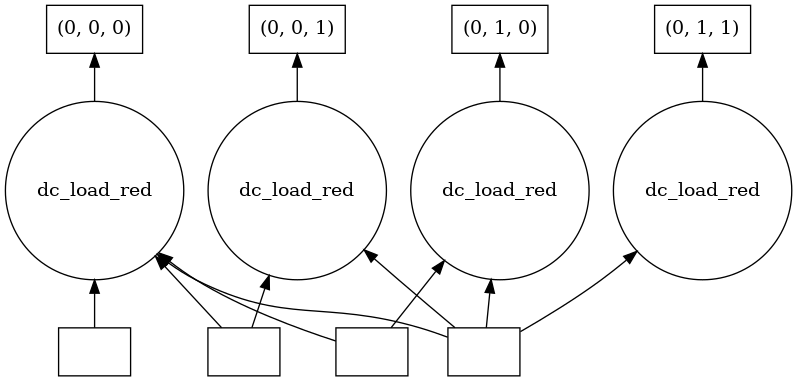

In [10]:
lazy_data.red.data.visualize()

**The task graph is read from bottom to top.**

1. The four rectangles at the bottom of the graph are the database entries describing the files that need to be read to load the data.

2. Above the rectangles are individual load commands that will do the reading.
There is one for each chunk.
The arrows describe which files need to be read for each operation: the chunk on the left needs data from all four database entries, whereas the chunk on the right only needs data from one.

3. At the very top are the indexes of the chunks that will make up the final array.

### Adding more tasks

The power of this method comes from chaining tasks together before loading the data.
This is because Dask will only load the data that is required by the final operation in the chain.

We can demonstrate this by requesting only a small portion of the red band.
If we do this for the lazy-loaded data, we can view the new task graph:

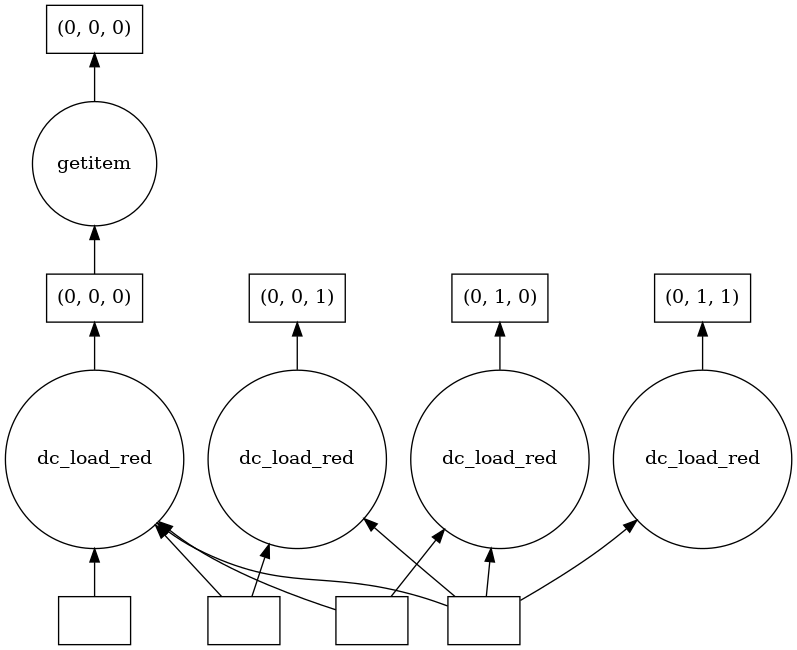

In [11]:
extract_from_red = lazy_data.red[:, 100:200, 100:200]
extract_from_red.data.visualize()

Notice that the new task `getitem` has been added, and that it only applies to the left-most chunk.
If we call `.load()` on the `extract_from_red` Dask array, Dask trace the operation back through the graph to find only the relevant data.
This can save both memory and time.

We can establish that the above operation yields the same result as loading the data without Dask and subsetting it by running the command below:

In [12]:
lazy_red_subset = extract_from_red.load()
data_red_subset = data.red[:, 100:200, 100:200]

print(f"The loaded arrays match: {lazy_red_subset.equals(data_red_subset)}")

The loaded arrays match: True


Since the arrays are the same, it is worth using lazy-loading to chain operations together, then calling `.load()` when you're ready to get the answer.
This saves time and memory, since Dask will only load the input data that is required to get the final output. 
In this example, the lazy-load only needed to load a small section of the `red` band, whereas the original load to get `data` had to load the `red`, `green` and `blue` bands, then subset the `red` band, meaning time was spent loading data that wasn't used.

### Multiple tasks

The power of using lazy-loading in Dask is that you can continue to chain operations together until you are ready to get the answer.

Here, we chain multiple steps together to calculate a new band for our array. Specifically, we use the `red` and `nir` bands to calculate the normalized difference vegetation index:

In [13]:
band_diff = lazy_data.nir - lazy_data.red
band_sum = lazy_data.nir + lazy_data.red

lazy_data['ndvi'] = band_diff / band_sum

Doing this adds the new `ndvi` Dask array to the `lazy_data` dataset:

In [14]:
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Now that the operation is defined, we can view its task graph:

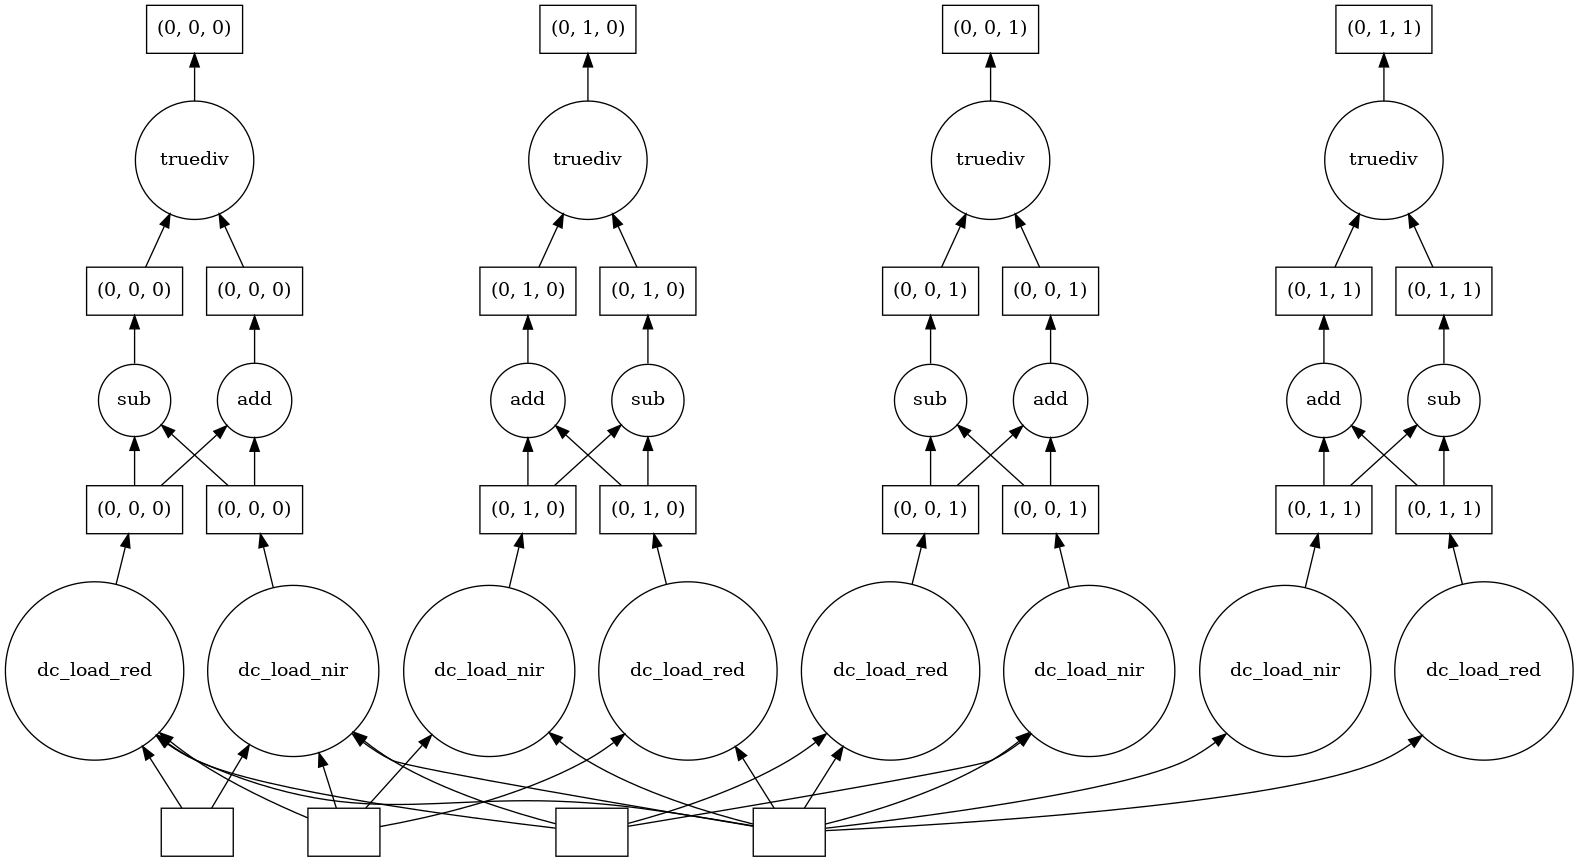

In [15]:
lazy_data.ndvi.data.visualize()

Reading the graph bottom-to-top, we can see the equation taking place. The `add` and `sub` are performed on each band before being divided.

We can see how each output chunk is independent from the others.  This means we could calculate each chunk without ever having to load all of the bands into memory at the same time.

Finally, we can calculate the NDVI values by calling the `.load()` command.
We'll store the result in the `ndvi_load` variable:

In [16]:
ndvi_load = lazy_data.ndvi.load()
ndvi_load

<xarray.DataArray 'ndvi' (time: 1, y: 5976, x: 4825)>
array([[[0.18406369, 0.19027307, 0.21399387, ..., 0.16188377,
         0.16096267, 0.1587973 ],
        [0.1926359 , 0.20721574, 0.21377373, ..., 0.16175794,
         0.1621467 , 0.15830174],
        [0.20757825, 0.22137239, 0.22728584, ..., 0.16196114,
         0.16285027, 0.15789871],
        ...,
        [0.12299319, 0.12232836, 0.12134761, ..., 0.1669503 ,
         0.16041473, 0.16174316],
        [0.1214985 , 0.11990734, 0.11989214, ..., 0.1669503 ,
         0.16041473, 0.16174316],
        [0.12155581, 0.11847012, 0.12067493, ..., 0.15935757,
         0.15618413, 0.16158246]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933

Note that running the `.load()` command also modifies the `ndvi` entry in the `lazy_load` dataset:

In [17]:
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 0.1841 0.1903 0.214 ... 0.1562 0.1616
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

You can see that `ndvi` is a number, whereas all the other variables are Dask arrays.

### Keeping variables as Dask arrays
If you wanted to calculate the NDVI values, but leave `ndvi` as a dask array in `lazy_load`, you can use the `.compute()` command instead.

To demonstrate this, we first redefine the `ndvi` variable so that it becomes a Dask array again

In [18]:
lazy_data['ndvi'] = band_diff / band_sum
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Now, we perform the same steps as before to calculate NDVI, but use `.compute()` instead of `.load():`

In [19]:
ndvi_compute = lazy_data.ndvi.compute()
ndvi_compute

<xarray.DataArray 'ndvi' (time: 1, y: 5976, x: 4825)>
array([[[0.18406369, 0.19027307, 0.21399387, ..., 0.16188377,
         0.16096267, 0.1587973 ],
        [0.1926359 , 0.20721574, 0.21377373, ..., 0.16175794,
         0.1621467 , 0.15830174],
        [0.20757825, 0.22137239, 0.22728584, ..., 0.16196114,
         0.16285027, 0.15789871],
        ...,
        [0.12299319, 0.12232836, 0.12134761, ..., 0.1669503 ,
         0.16041473, 0.16174316],
        [0.1214985 , 0.11990734, 0.11989214, ..., 0.1669503 ,
         0.16041473, 0.16174316],
        [0.12155581, 0.11847012, 0.12067493, ..., 0.15935757,
         0.15618413, 0.16158246]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933

You can see that the values have been calculated, but as shown below, the `ndvi` variable is kept as a Dask array.

In [20]:
lazy_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 4825, y: 5976)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 -2.501e+06 -2.501e+06 ... -2.68e+06 -2.681e+06
  * x            (x) float64 2.316e+06 2.316e+06 2.316e+06 ... 2.46e+06 2.46e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

Using `.compute()` can allow you to calculate in-between steps and store the results, without modifying the original Dask dataset or array. 
However, be careful when using `.compute()`, as it may lead to confusion about what you have and have not modified, as well as multiple computations of the same quantity.

## Further Resources

For further reading on how Dask works, and how it is used by xarray, see these resources:

 * http://xarray.pydata.org/en/stable/dask.html
 * https://dask.readthedocs.io/en/latest/
 * http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/

### Other notebooks
This is the last notebook in the beginner's guide; if anything was unclear, we recommend revising the relevant notebook:

1. [Jupyter Notebooks](01_Jupyter_notebooks.ipynb)
2. [Products and Measurements](02_Products_and_measurements.ipynb)
3. [Loading data](03_Loading_data.ipynb)
4. [Plotting](04_Plotting.ipynb)
5. [Performing a basic analysis](05_Basic_analysis.ipynb)
6. [Introduction to numpy](06_Intro_to_numpy.ipynb)
7. [Introduction to xarray](07_Intro_to_xarray.ipynb)
8. **Parallel processing with Dask (this notebook)**

Once you have completed the above eight tutorials, join advanced users in exploring:

* The "Datasets" directory in the repository, where you can explore DE Africa products in depth.
* The "Frequently used code" directory, which contains a recipe book of common techniques and methods for analysing DE Africa data.
* The "Real-world examples" directory, which provides more complex workflows and analysis case studies.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** March 2020

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://)()